### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.sched_setaffinity(0, {8}) 

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [2]:

train_data = pd.read_csv('lab1_train.csv', delimiter=',')
test_data = pd.read_csv('lab1_test.csv', delimiter=',')


# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


In [3]:
def visualize_sensor_data(df, window=None, sensors=None, title="Sensor Data Visualization"):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title(title)
    plt.legend()

    plt.show()

# Familiarity
---
To start we take a look at all signals

/nix/store/4vmqc642fjam58ap7zpkg38hmaj2nyha-python3.12-ipython-8.29.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


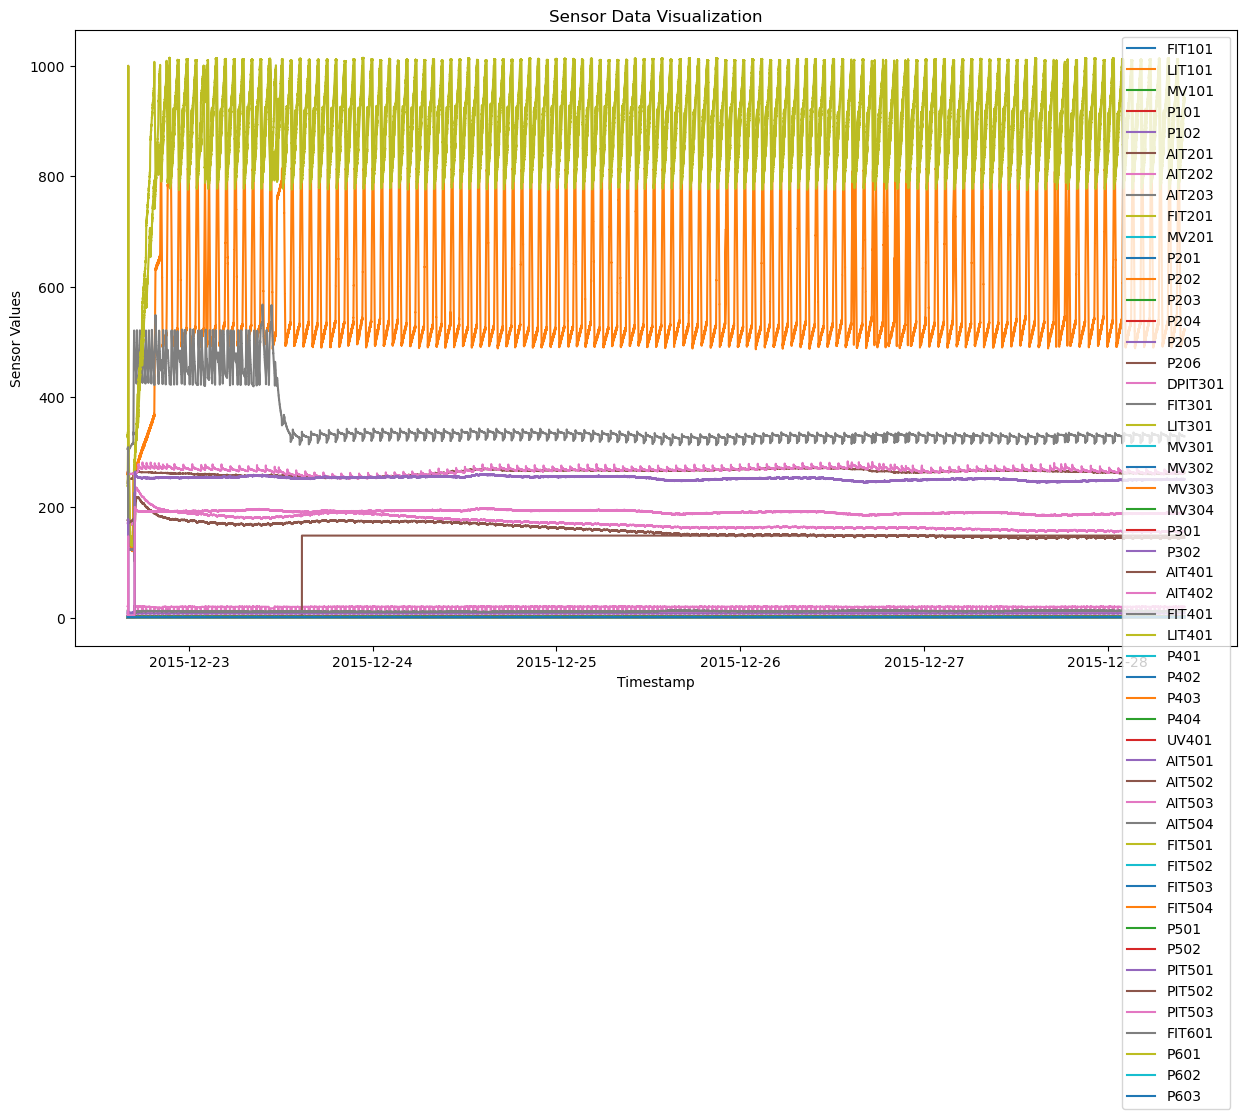

In [4]:
visualize_sensor_data(train_data)

From this plot we observe that the first region of the data is a lot more turbolent than the later part of the data, lets split it up 

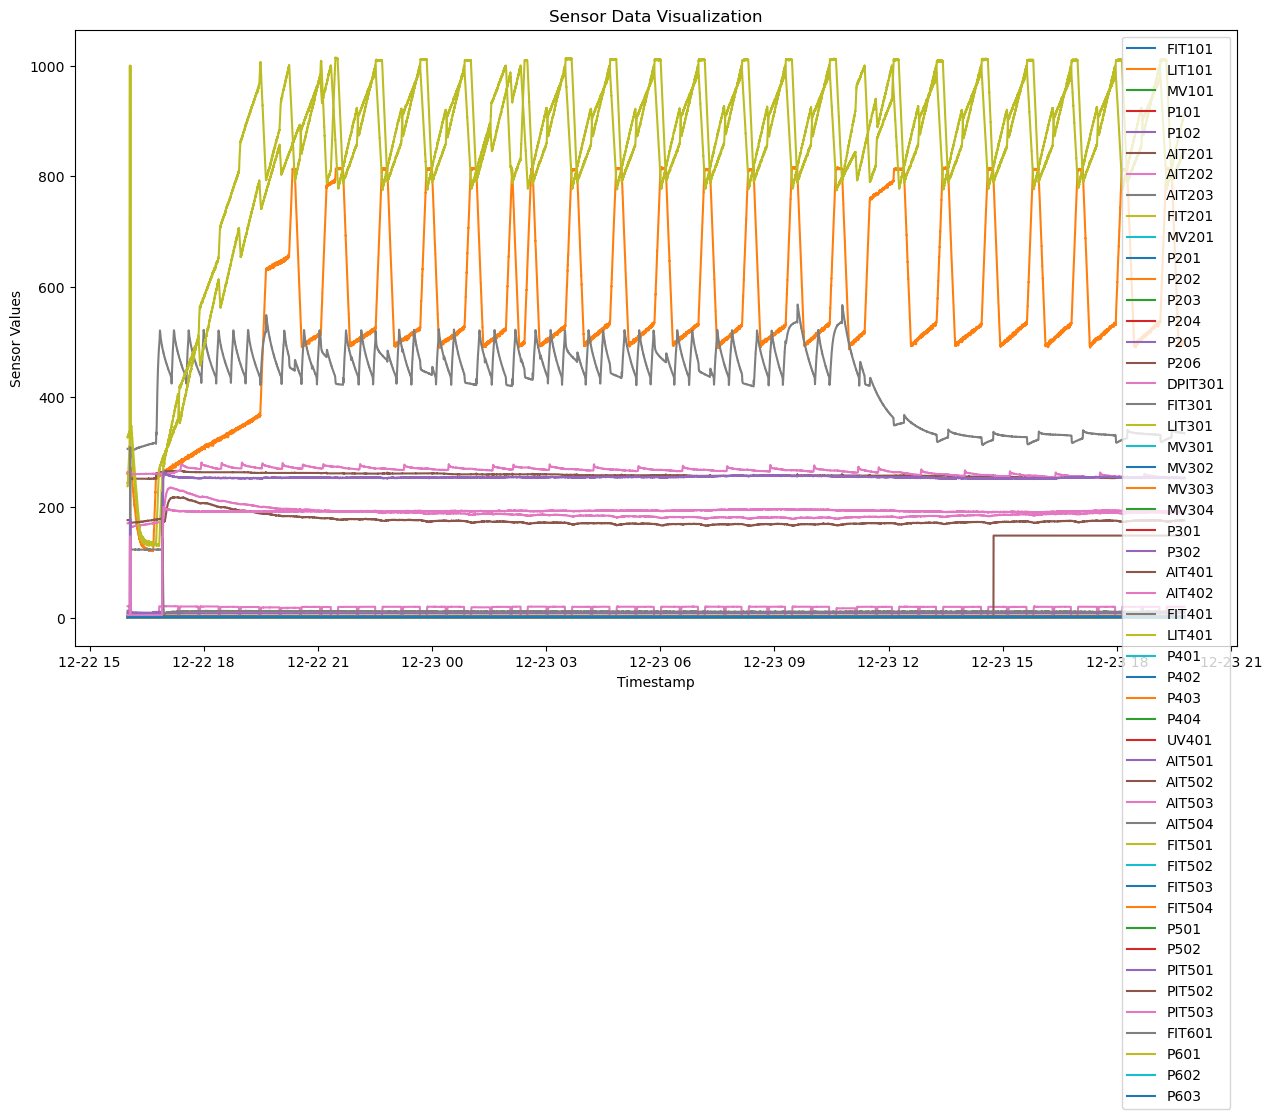

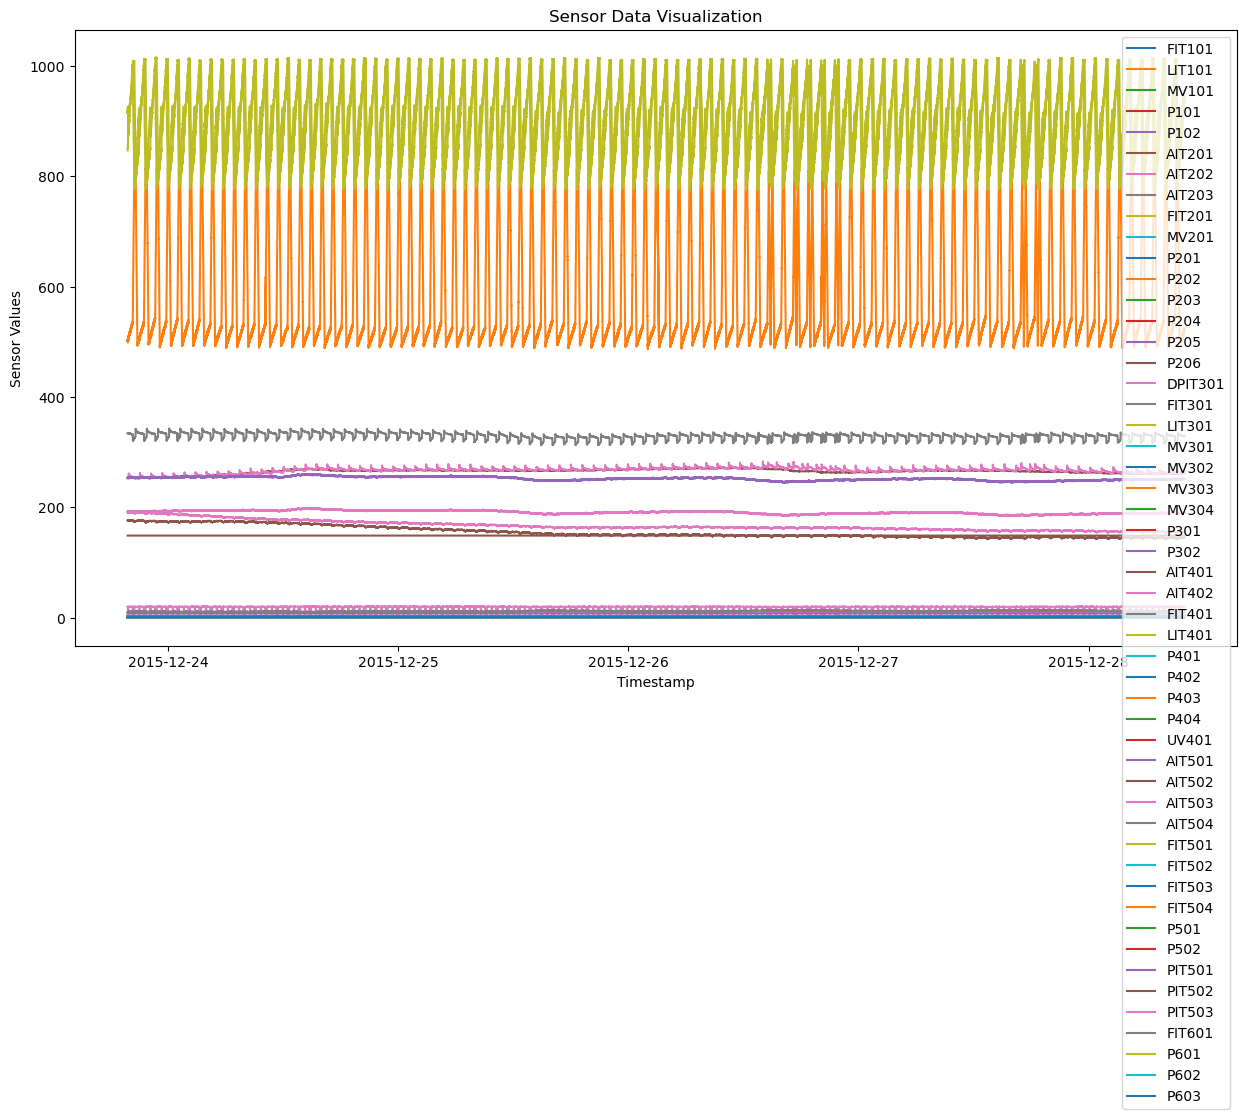

In [5]:
visualize_sensor_data(train_data, window=(0, 100000))
visualize_sensor_data(train_data, window=(100000, 1000000))

Unfortunately, the amptitude of the data is not uniform, which makes it hard to spot patterns in all signals. 

Lets split up the data based on the mean of each signal. Note that since some signals have large positive and negative peaks which would stretch the scale of the resulting graph, we also take minimum and maximum values into account when categorizing.

In [6]:
time_stamps = train_data.iloc[:, 0]
norm_attack = train_data.iloc[:, -1:]
sensors = train_data.iloc[:, 1:-1]

upper_range   = sensors.loc[:, (sensors.mean() > 300 ) | (sensors.max()  > 300)]
mid_range     = sensors.loc[:, (sensors.mean() >= 5 ) & (sensors.mean() <= 300)]
lower_range   = sensors.loc[:, (sensors.mean() < 5  ) & (sensors.mean() > 1)]
lowest_range  = sensors.loc[:, (sensors.mean() <= 1  ) ]

upper_range_data  = pd.concat([time_stamps, upper_range ], axis=1)
mid_range_data    = pd.concat([time_stamps, mid_range   ], axis=1)
lower_range_data  = pd.concat([time_stamps, lower_range ], axis=1)
lowest_range_data = pd.concat([time_stamps, lowest_range], axis=1)


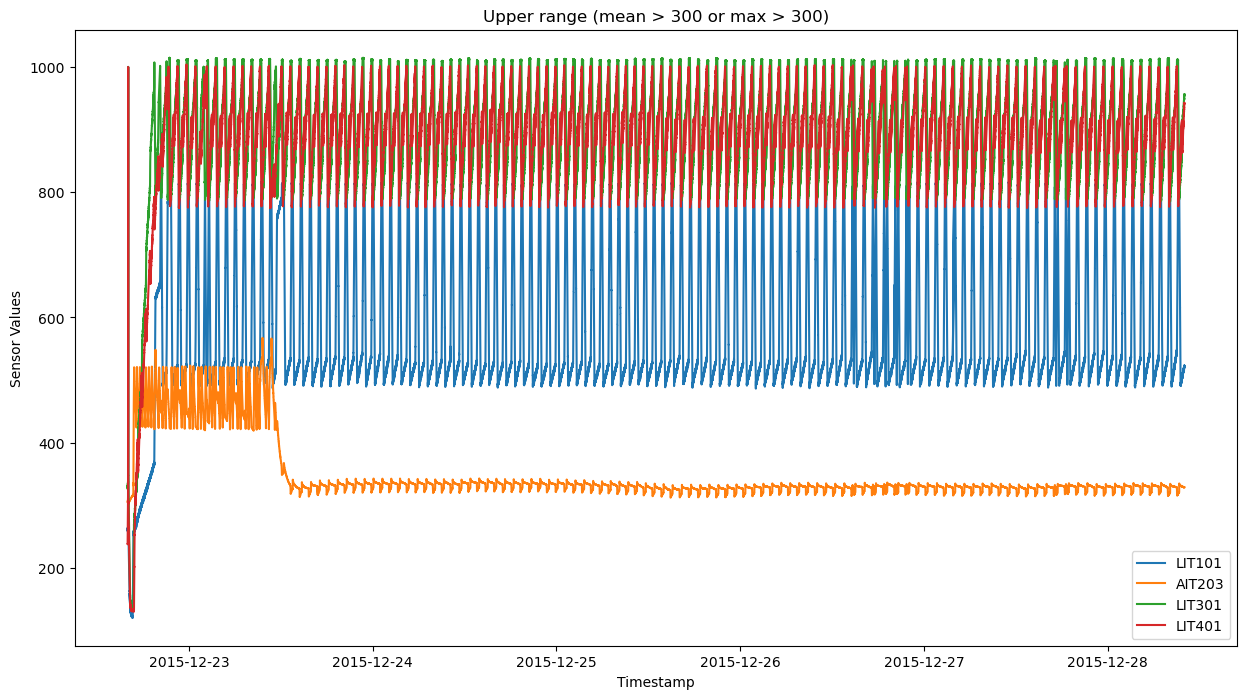

/nix/store/4vmqc642fjam58ap7zpkg38hmaj2nyha-python3.12-ipython-8.29.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


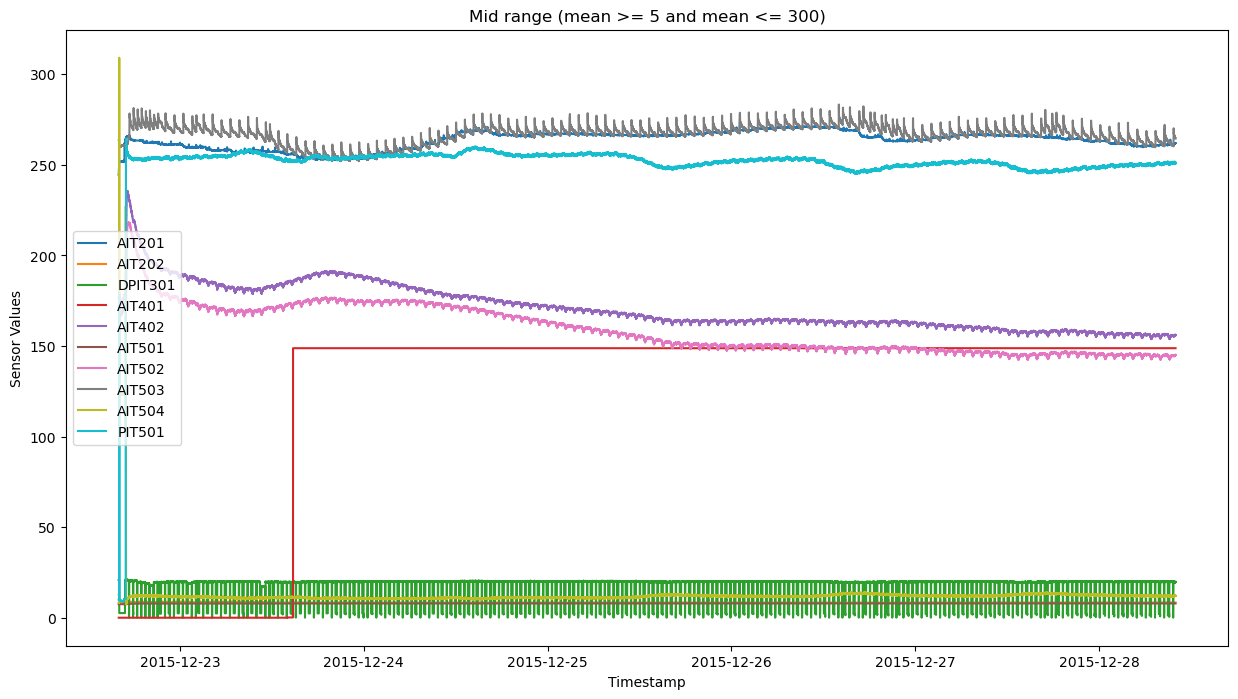

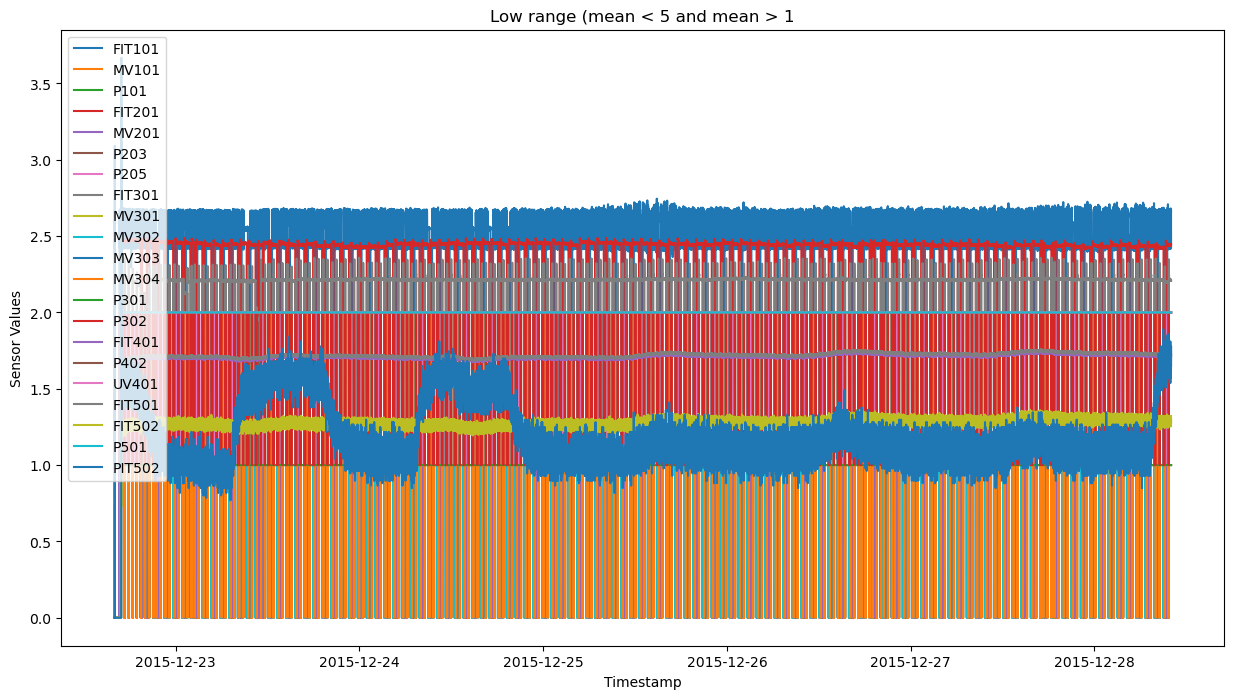

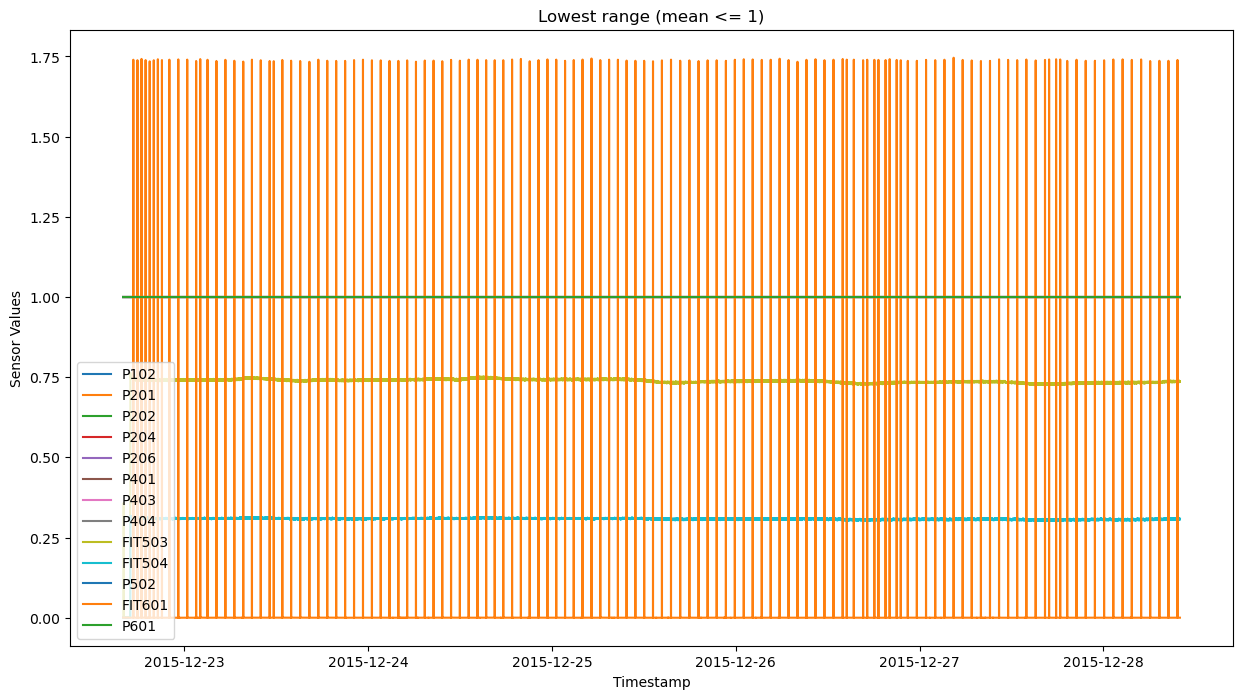

In [7]:
visualize_sensor_data(upper_range_data[:-1],  title="Upper range (mean > 300 or max > 300)")
visualize_sensor_data(mid_range_data[:-1],    title="Mid range (mean >= 5 and mean <= 300)")
visualize_sensor_data(lower_range_data[:-1],  title="Low range (mean < 5 and mean > 1")
visualize_sensor_data(lowest_range_data[:-1], title="Lowest range (mean <= 1)")


By seperating the signal we are able to look at them more closely, since the smaller details dont get crunched by the scale of the large signals 

In [8]:
datasets = {
    "Original Data": train_data,
    "Higher Range Data": upper_range_data,
    "Mid Range Data": mid_range_data,
    "Lower Range Data": lower_range_data,
    "Lowest Range Data": lowest_range_data,
}

for name, data in datasets.items():
    print(f"{name}:")
    print(f"\tColumn Names: {list(data.columns[1:])}")
    print(f"\tColumn Count: {len(data.columns[1:])}")
    print()


Original Data:
	Column Names: ['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603', 'Normal/Attack']
	Column Count: 52

Higher Range Data:
	Column Names: ['LIT101', 'AIT203', 'LIT301', 'LIT401', 'AIT504']
	Column Count: 5

Mid Range Data:
	Column Names: ['AIT201', 'AIT202', 'DPIT301', 'AIT401', 'AIT402', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'PIT501', 'PIT503']
	Column Count: 11

Lower Range Data:
	Column Names: ['FIT101', 'MV101', 'P101', 'FIT201', 'MV201', 'P203', 'P205', 'FIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'FIT401', 'P402', 'UV401', 'FIT501', 'FIT502

Unfortunately the lower range data plot is still a bit cluttered, lets seperate the signals based on variance

In [37]:

lower_range_signals = lower_range_data.iloc[:, 1:-1]
variances = lower_range_signals.var()
sorted_variances = variances.sort_values()

print("Signals in \"lower_range_signals\", sorted by variance:")
print(sorted_variances)


var_size = len(sorted_variances)
window_size = var_size // 3 

variance_splits = []
for i in range(3):
  start = i * window_size 
  end = (i + 1) * window_size
  if i == 2:
    end += 1

  split_columns = sorted_variances.index[start:end]
  split_df = pd.concat([time_stamps, lower_range_signals[split_columns]], axis=1)
  variance_splits.append(split_df)



Signals in "lower_range_signals", sorted by variance:
P301      0.003952
P402      0.006372
UV401     0.006382
P501      0.006674
FIT502    0.010890
MV301     0.012220
FIT401    0.018932
FIT501    0.019134
MV303     0.028658
MV304     0.038254
PIT502    0.047082
P302      0.147428
MV302     0.173651
P101      0.189061
P203      0.189994
MV201     0.197628
MV101     0.210377
P205      0.224533
FIT301    0.682261
FIT201    1.128868
FIT101    1.288979
dtype: float64


8


/nix/store/4vmqc642fjam58ap7zpkg38hmaj2nyha-python3.12-ipython-8.29.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


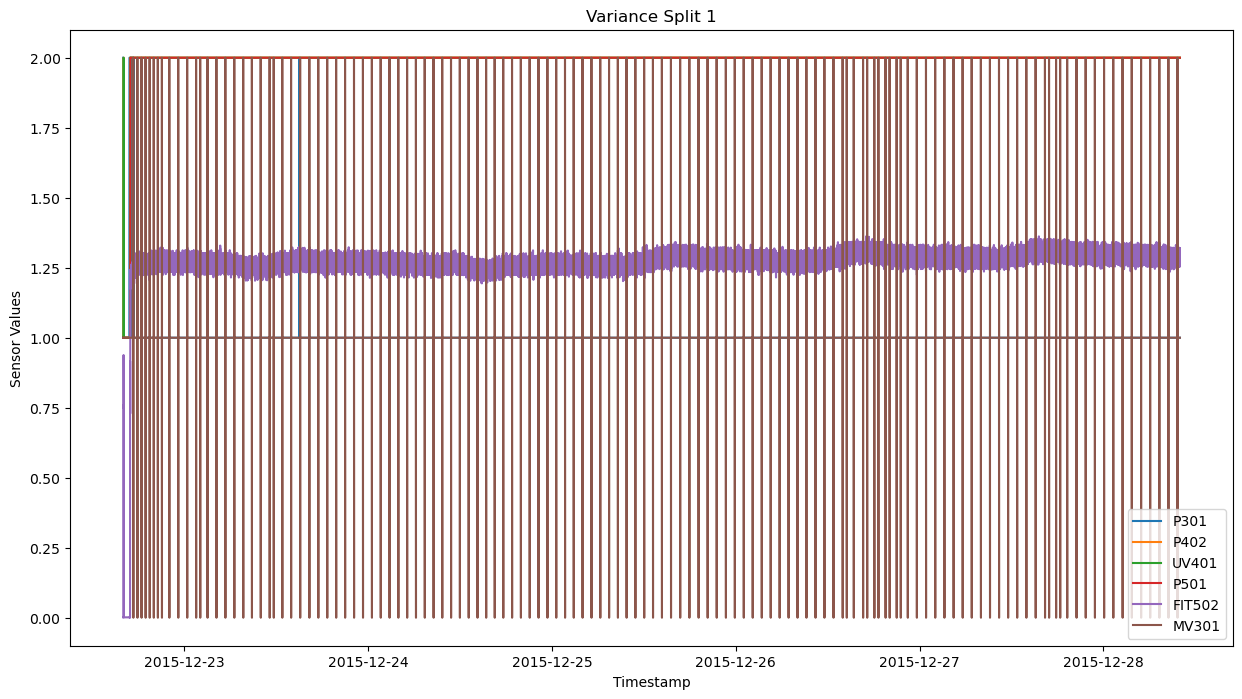

8


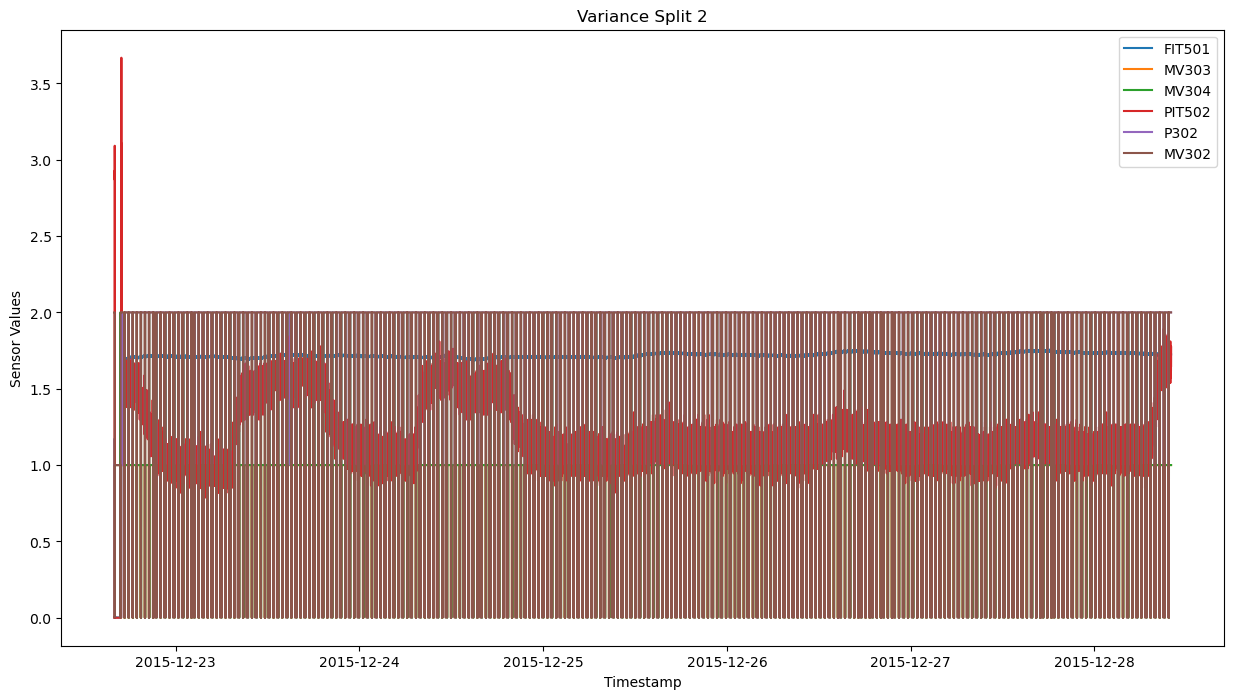

8


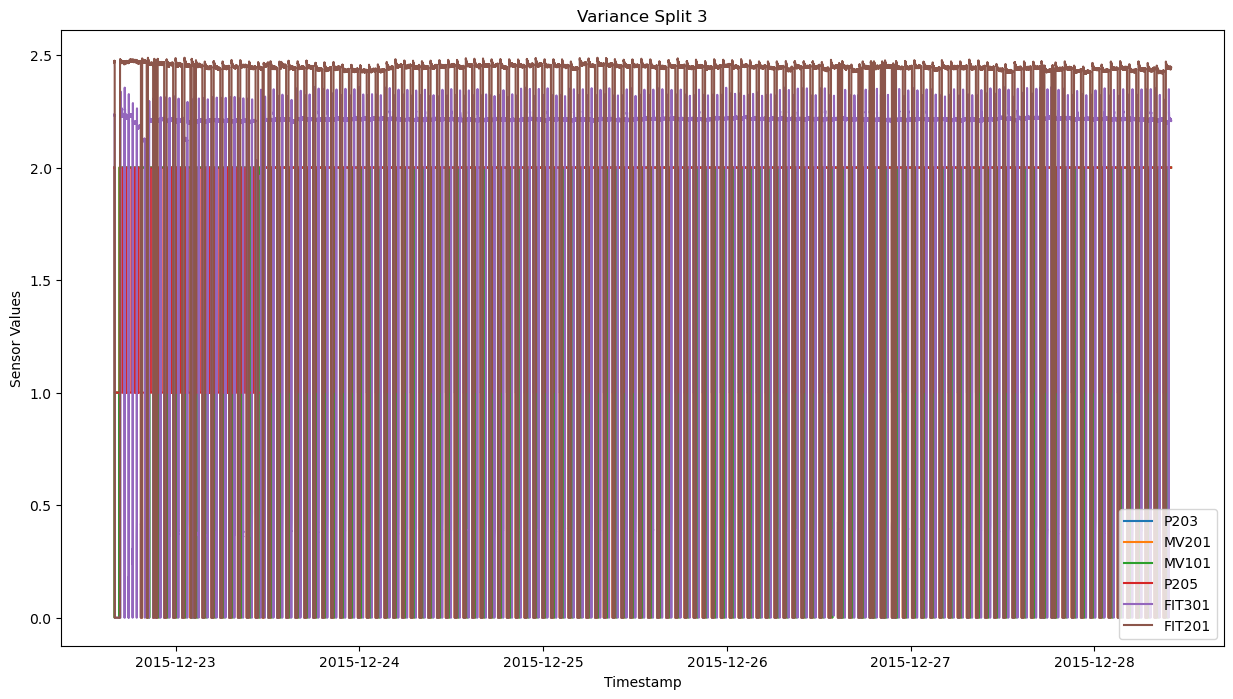

In [36]:
for i, split in enumerate(variance_splits):
  visualize_sensor_data(split, title=f"Variance Split {i + 1}")


# Visual Analysis
After these steps we have a clearer overview of the data.

From the plots we can conclude the following things

## Signal types
There appear to be 3 types of signals, continous, binary and cyclic.
- Continous signals do not have a set range. Anomalies are charterized by signal amptitude
- Binary signals switch between a high state of an arbitrary value and a low state of zero at a constant frequency. Anomalies are charterized by changes in frequency
- Cyclic signals are a mix of continous and binary signals. They switch between arbitrary low and high states over a time period and there average amptitude can change aswell.  Anomalies seem to charterized by both frequency changes and less often amptitude changes  

# DTW
---

I picked signal "FIT101" because it has a high variance and looked interesting 


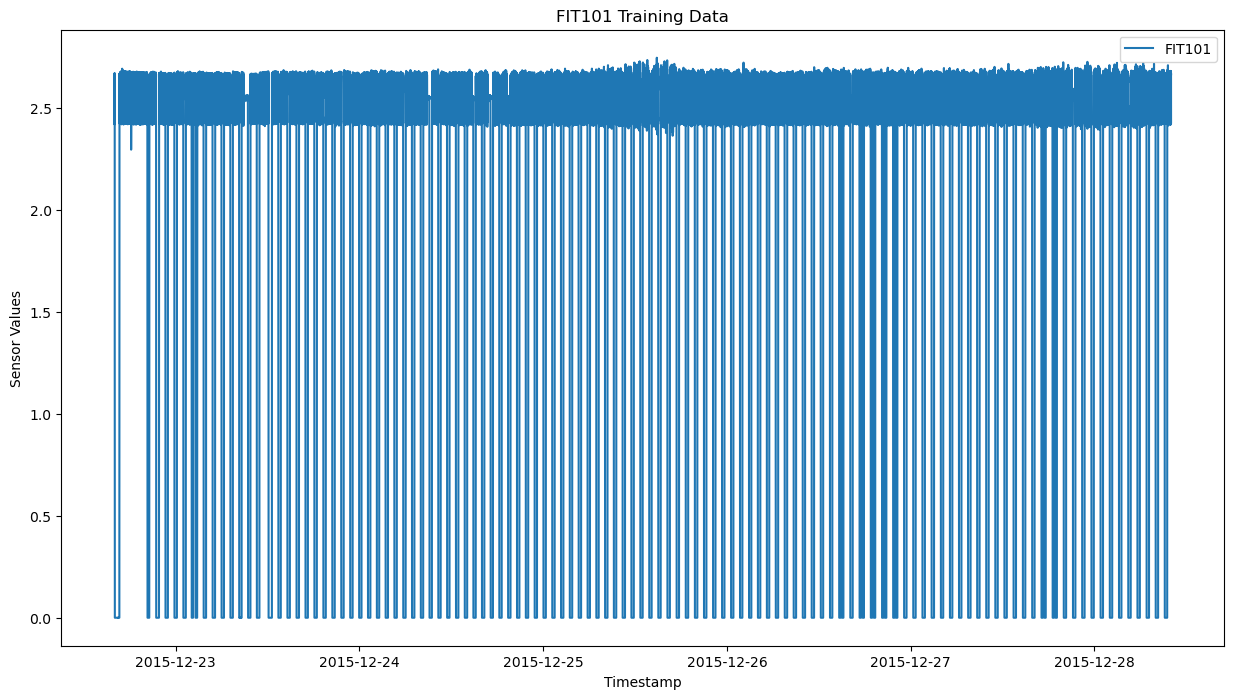

In [38]:
visualize_sensor_data(train_data, title=f"FIT101 Training Data", sensors=["FIT101"])

In order to make it usuable for dynamic time warping we need to clean it up a bit

First we cut of all the obvious anonomlous regions

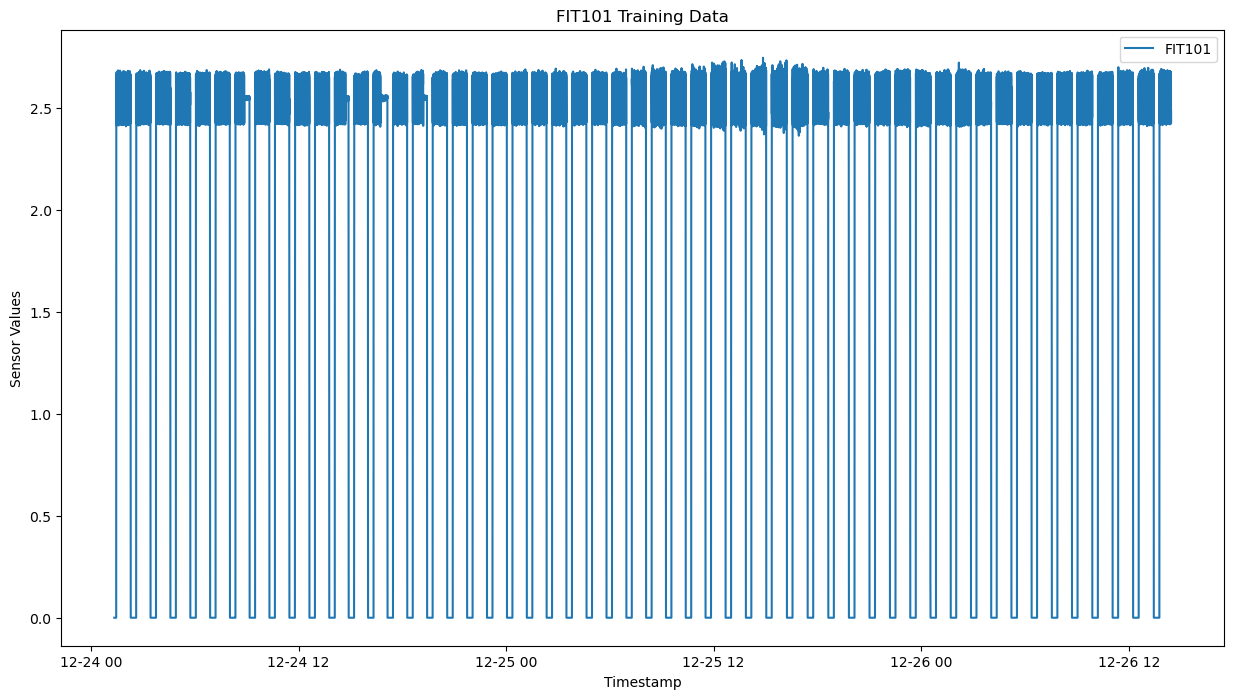

In [39]:
cleaned_data = train_data.loc[120000:340000]

visualize_sensor_data(cleaned_data, title=f"FIT101 Training Data", sensors=["FIT101"])

Lets examine the signal a bit closer

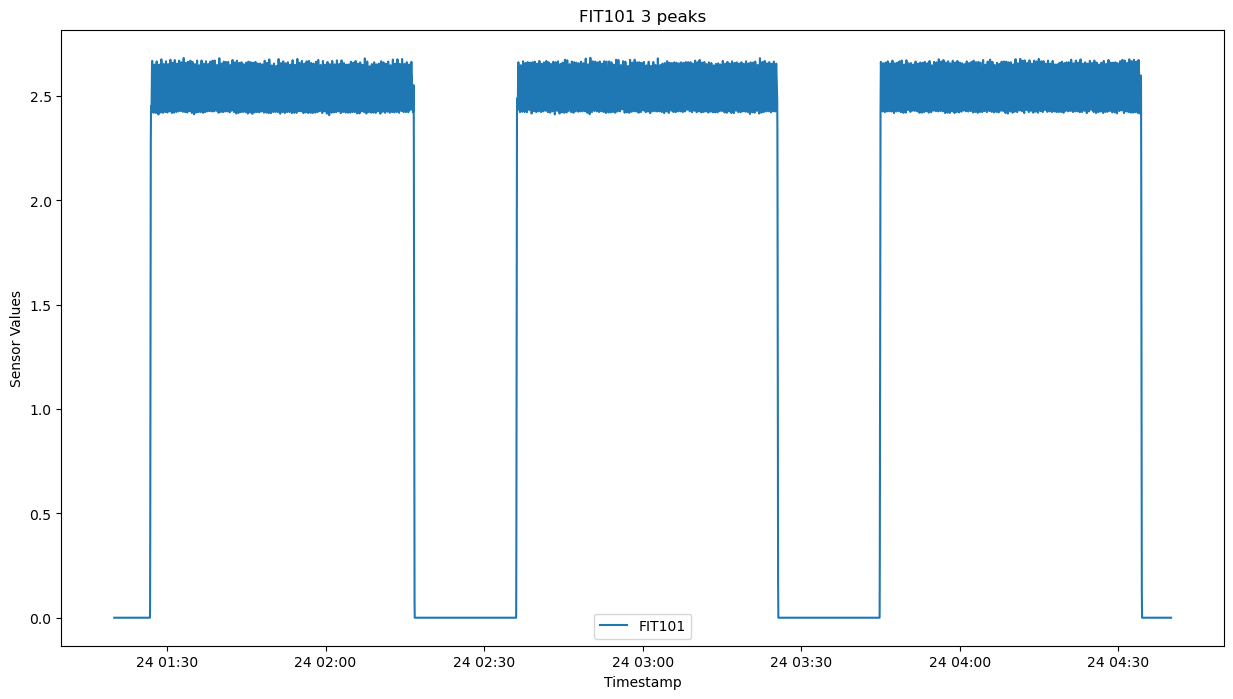

In [40]:
peaks = train_data.loc[120000:132000]


visualize_sensor_data(peaks_3, title=f"FIT101 3 peaks", sensors=["FIT101"])



Based on this close oberservation we could decide to clean the signal up even more, but it is good enough for now

#### Preparing the data

The the time complexity of Dynamic Time Warping is O(n^2), this means running the algorithm over the entirety of both signal is not feasable. To combat this there are 2 solutions

#### Sliding windows
By taking the DTW of a sliding window we limit the size of the input of DTW, which drastically reduces the calculations required because of its time complexity 

#### Sampling
By picking n amount of data points using an equal distribution we reduce the amount of calculations needed while keeping the data representative 

In [51]:

def sample_window(data, sample_ratio):
  data_size = len(data)
  sample_idx = np.linspace(0, data_size - 1, round(data_size * sample_ratio)).astype(int)
  return data[sample_idx]

def create_windows(data, window_size, max_window_count, sample_ratio):
  out = []
  count = 0
  data_size = len(data) 
  
  stride = round((data_size - window_size) / (max_window_count - 1)) # Creates evenly spaced windows
  for i in range(0,data_size, stride):
    window = data[i:i+window_size]
    sample = sample_window(window, sample_ratio)
    out.append(sample)
  return out, stride


signal = "FIT101"

train_signal = cleaned_data[signal].to_numpy()
test_signal = test_data[signal].to_numpy()

sample_ratio = 0.01
window_size = 2000
train_windows, train_stride = create_windows(train_signal, window_size, 20, sample_ratio) 
test_windows, test_stride = create_windows(test_signal, window_size, 3000,sample_ratio)

print("=== Train Signal (Sanitized) ===")
print(f"Size\t\t\t{len(train_signal)}")
print(f"Window size\t\t{window_size}")
print(f"Window size sampled\t{len(train_windows[0])}")
print(f"Window count\t\t{len(train_windows)}")
print(f"Train stride\t\t{train_stride}")

print()
print("=== Test Signal ===")
print(f"Size\t\t\t{len(test_signal)}")
print(f"Window size\t\t{window_size}")
print(f"Window size sampled\t{len(test_windows[0])}")
print(f"Window count\t\t{len(test_windows)}")
print(f"Test stride\t\t{test_stride}")
print()
print(f"Sample percentage \t{sample_ratio * 100}%")


=== Train Signal (Sanitized) ===
Size			220001
Window size		2000
Window size sampled	20
Window count		20
Train stride		11474

=== Test Signal ===
Size			449919
Window size		2000
Window size sampled	20
Window count		3020
Test stride		149

Sample percentage 	1.0%


We now have everything in place to run the DTW

In [47]:
import math


def dynamic_time_warping(s, t):
  n = len(s)
  m = len(t)
  
  prev = np.full(m + 1, np.inf)
  curr = np.full(m + 1, np.inf)
  
  prev[0] = 0
  
  for y in range(1, n + 1):
    curr[0] = np.inf  
    for x in range(1, m + 1):
      cost = abs(s[y-1] - t[x-1])**2
      curr[x] = cost + min(prev[x], curr[x-1], prev[x-1])        
    prev, curr = curr, prev
  
  return math.sqrt(prev[m])


distances = []
sample_ratio = 0.05

print(f"Running DTW for {len(test_windows)} iterations")

for i, test_window in enumerate(test_windows):
  min_distance = np.inf  
  for train_window in train_windows:
    distance = dynamic_time_warping(test_window, train_window)
    min_distance  = min(distance, min_distance)
      
  
  print(f"Computed window {i}")
  distances.append(min_distance)



Running DTW for 3020 iterations with sample ratio 0.05, window size 20
Computed window 0
Computed window 1
Computed window 2
Computed window 3
Computed window 4
Computed window 5
Computed window 6
Computed window 7
Computed window 8
Computed window 9
Computed window 10
Computed window 11
Computed window 12
Computed window 13
Computed window 14
Computed window 15
Computed window 16
Computed window 17
Computed window 18
Computed window 19
Computed window 20
Computed window 21
Computed window 22
Computed window 23
Computed window 24
Computed window 25
Computed window 26
Computed window 27
Computed window 28
Computed window 29
Computed window 30
Computed window 31
Computed window 32
Computed window 33
Computed window 34
Computed window 35
Computed window 36
Computed window 37
Computed window 38
Computed window 39
Computed window 40
Computed window 41
Computed window 42
Computed window 43
Computed window 44
Computed window 45
Computed window 46
Computed window 47
Computed window 48
Computed

Lets plot the results

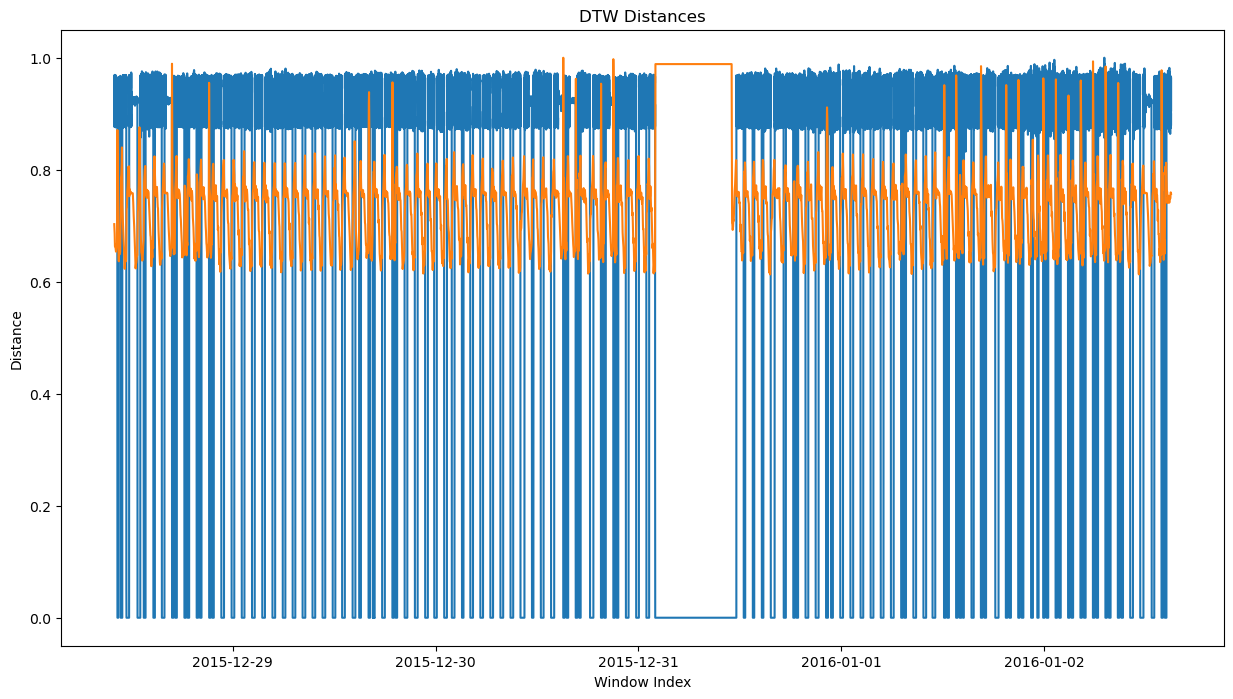

In [52]:

distances = np.array(distances)


distances /= max(distances) 
test_signal /= max(test_signal)


train_time_stamp = train_data.iloc[:, 0]
test_time_stamp = test_data.iloc[:, 0]

stretched = np.linspace(0, len(distances)-1, test_signal.size)
interpolated_distances = np.interp(stretched, np.arange(len(distances)), distances)

plt.figure(figsize=(15, 8))

plt.plot(test_time_stamp, test_signal)
plt.plot(test_time_stamp, interpolated_distances)

plt.title("DTW Distances")
plt.xlabel("Window Index")
plt.ylabel("Distance")
plt.show()


After a bit of fidling with the input parameters data we can clearly see the correlation between anaomlies in the signal and peaks in the results of our calculation, by setting a threshold we can decide when to classify something as an anomalie

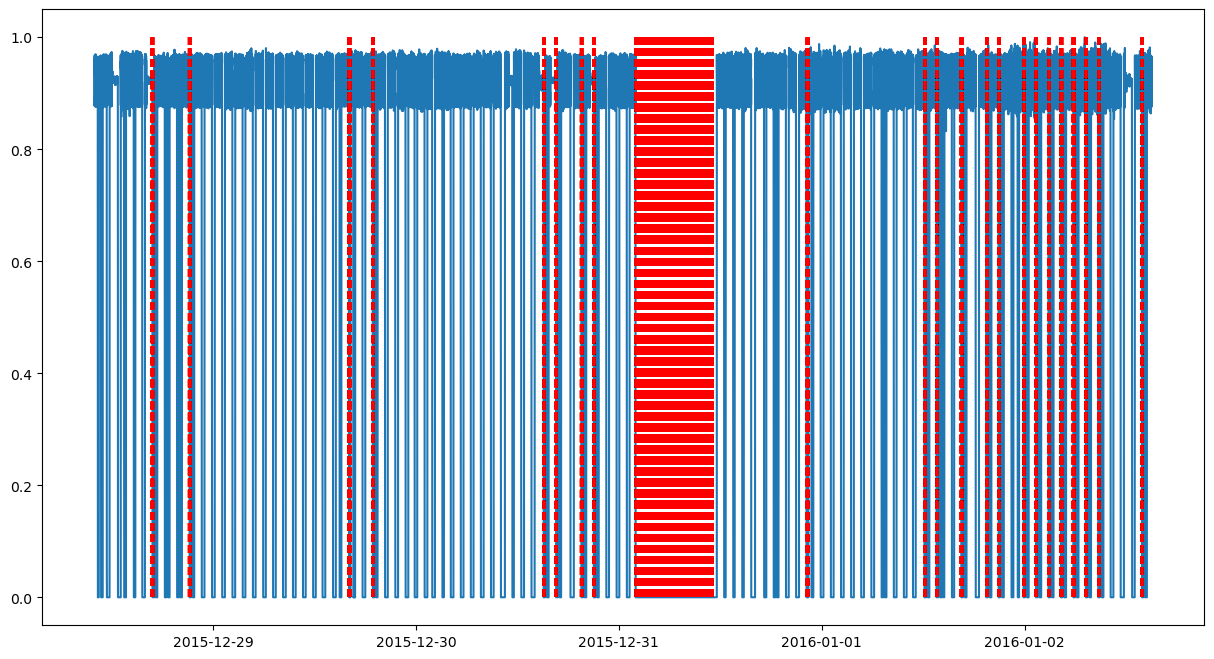

In [80]:


threshold = 0.9
anomalies = np.argwhere(interpolated_distances > threshold).flatten()

plt.figure(figsize=(15, 8))
plt.plot(test_time_stamp, test_signal)
plt.vlines(test_time_stamp[anomalies], 0, 1, colors="red",linestyles="dashed")
plt.show()

In this plot all possible anaomlies the our method found are marked, however depending on how sensitve you want the output to be this could be either to much or to little 

# PCA
---
Here we try a different way to detect anamolies

In [81]:

def principal_component_analysis(df, k):
  print(f"Taking PCA of {df.shape}")
  cov = np.cov(df, rowvar=False)
  print(f"Calculated cov matrix {cov.shape}")


  eigenvalues, eigenvectors = np.linalg.eig(cov)
  print(f"Calculated eigenvalues and vectors, count {len(eigenvalues)}")
  sorted_idx = np.argsort(eigenvalues)[::-1]
  top_k_idx = sorted_idx[:k]
  selected_eigenvectors = eigenvectors[:, top_k_idx]

  reduced_data = np.dot(df, selected_eigenvectors)
  print(f"Reduced data to matrix of {reduced_data.shape}")
  return reduced_data, selected_eigenvectors
    
def normalize(data):
  mean = np.mean(data, axis=0)
  std = np.std(data, axis=0)
  norm = (data - mean) / std
  norm = np.nan_to_num(norm, nan=0)
  return norm, mean, std

def reconstruct_data(reduced_data, eigenvectors):
  return np.dot(reduced_data, eigenvectors.T)

def compute_residuals(original_data, reconstructed_data):
  return np.linalg.norm(original_data - reconstructed_data, axis=1)



In [82]:
norm, mean, std = normalize(sensors["FIT101"])
norm = norm.reshape(-1, 1)
print(norm.shape)

print("Normalized data")


(496800, 1)
Normalized data


In [83]:
for i, test_window in enumerate(test_windows):
  min_residuals = np.inf  
  
  reduced_test_data, eigenvectors_test = principal_component_analysis(test_window, 30)
  pca_test = reconstruct_data(reduced_test_data, eigenvectors_test)
 
  for train_window in train_windows:
    
    combined_signal = np.concatenate([test_window, train_window])

    combined_signal_data, eigenvectors_combined = principal_component_analysis(combined_signal, 30)
    pca_combined_signal = reconstruct_data(reduced_data, eigenvectors)
    
    residuals = compute_residuals(pca_test, pca_train)
    min_residuals  = min(residuals, min_residuals)
  
  print(f"Computed window {i}")
  distances.append(min_distance)      



Taking PCA of (20,)
Calculated cov matrix ()


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

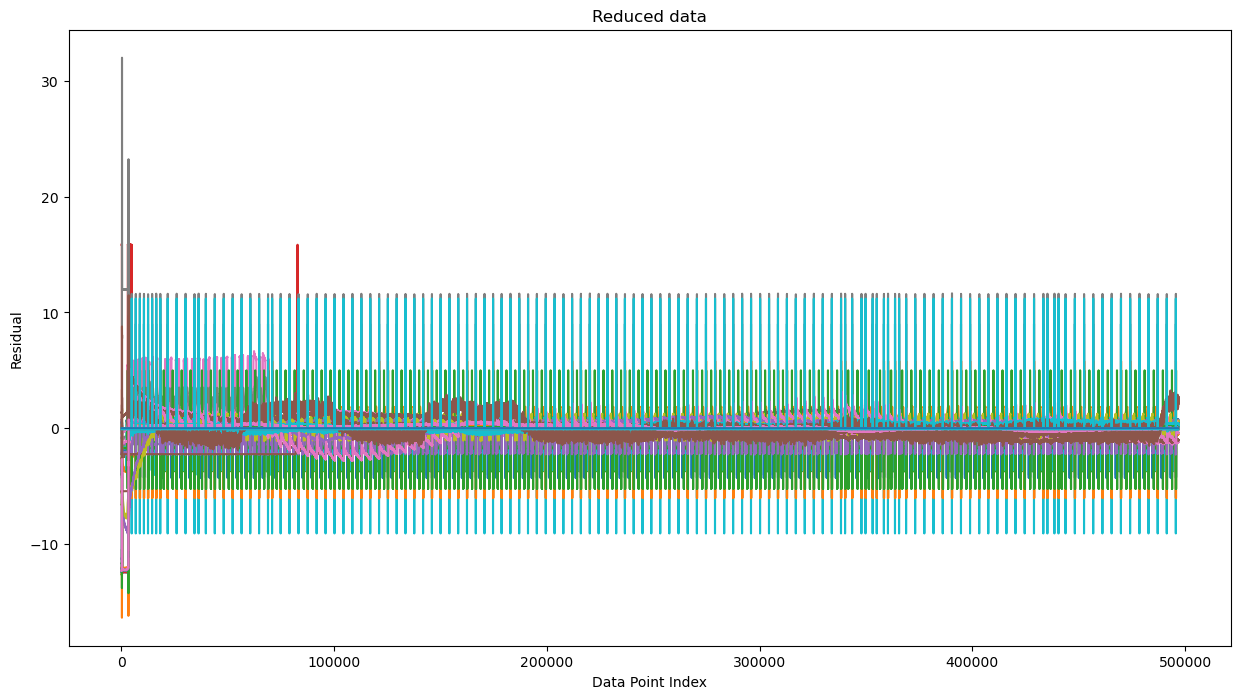

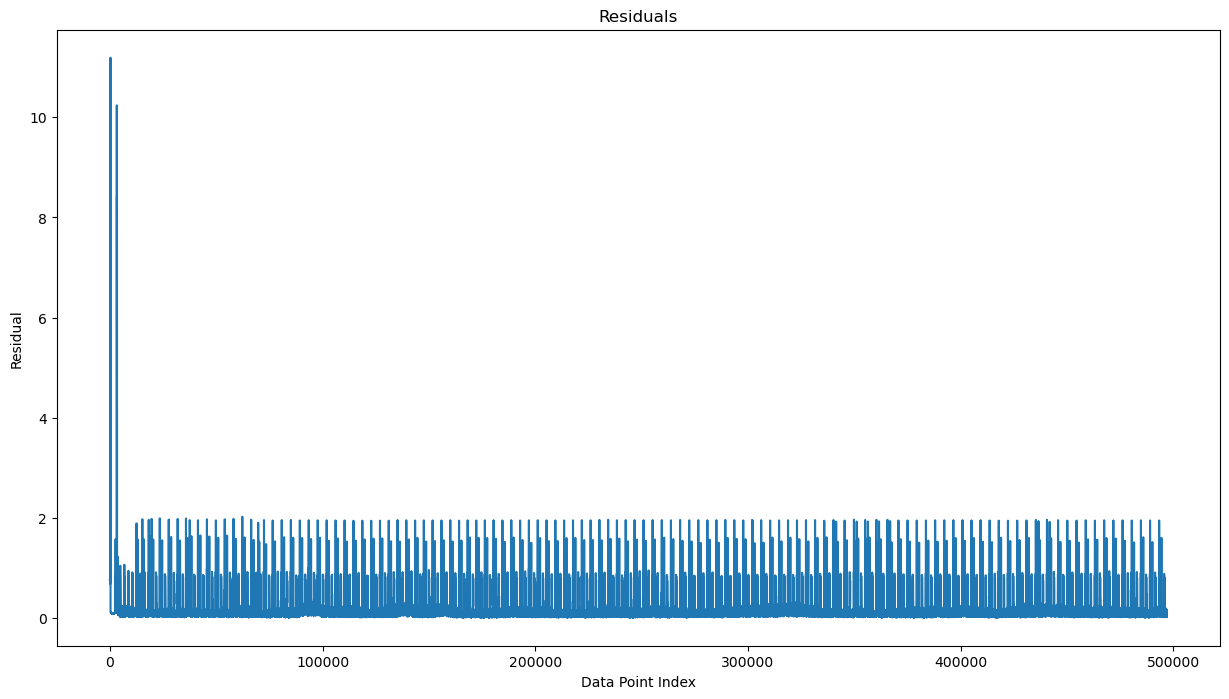

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(pca, label=f'PCA')

plt.xlabel('Data Point Index')
plt.ylabel('Residual')
plt.title('Reduced data')
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(residuals)

plt.xlabel('Data Point Index')
plt.ylabel('Residual')
plt.title('Residuals')
plt.show()
